In [159]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.font_manager
from sklearn import svm

In [20]:
data = pd.read_csv('numbers-on-unemployment-benefits.csv')
data.dropna(inplace=True)

In [27]:
signal = data['Numbers on Unemployment Benefits in Australia: monthly Jan 1956 ? Jul 1992']

In [28]:
pd.isnull(signal).sum()

0

In [29]:
type(signal)

pandas.core.series.Series

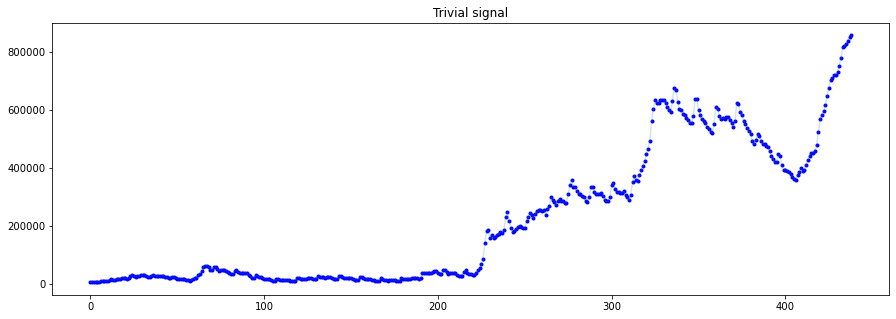

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(signal, 'b.')
plt.plot(signal, '-', alpha=0.2)
plt.title("Trivial signal")
plt.show()

Детектор №1

In [120]:
class MeanDetector:
    def __init__(self, threshold):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0

    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count

    def check(self, new_signal_value): 
        threshold_level = self.mean * self.threshold

        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

In [121]:
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    
    plt.figure(figsize=(14,8))
    plt.plot(signal, 'b.')
    plt.plot(signal, 'b-', alpha=0.15)
    plt.title('Signal')
    
    if stop_points:
        plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                      colors='r', linestyles='dotted')
    
    plt.show()

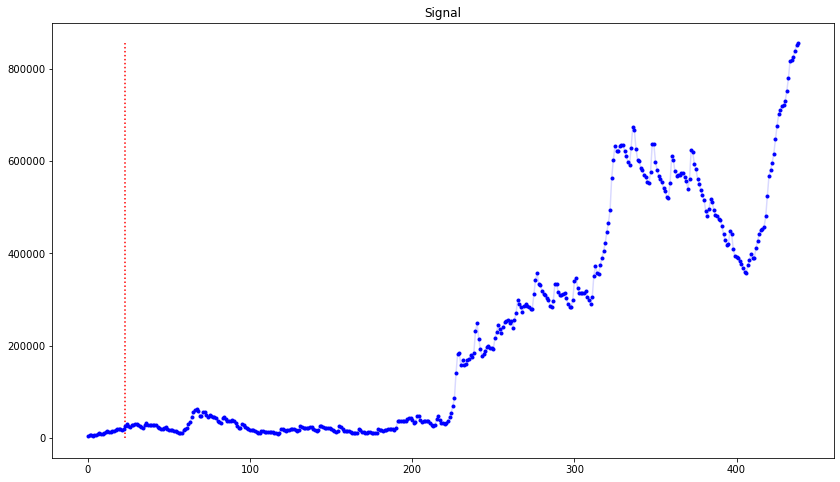

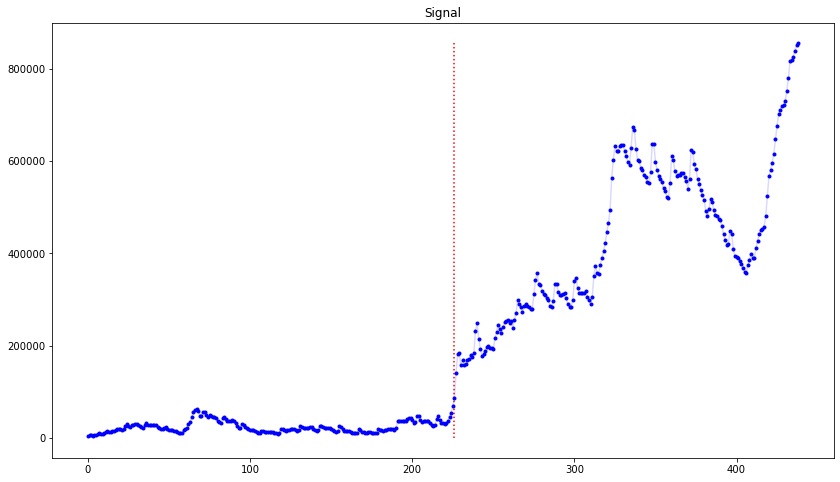

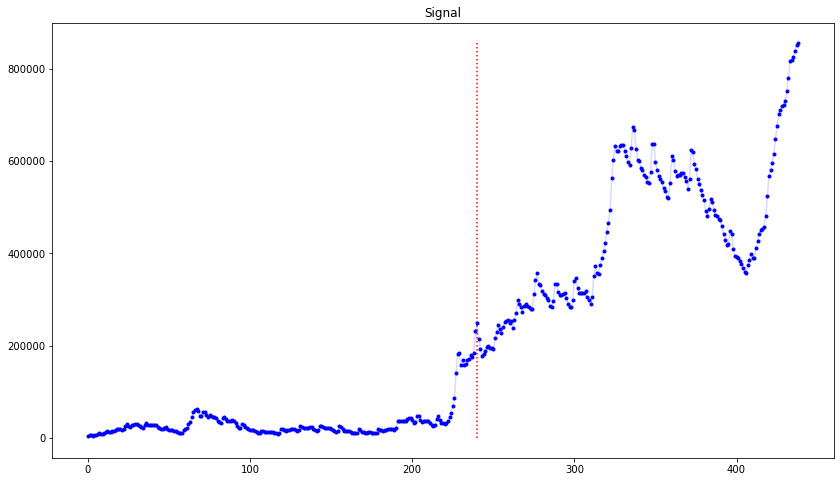

In [127]:
for a in [1, 2, 6.3]:
    simulate(MeanDetector(a), signal)

Детоктор № 2

In [128]:
class ZScoreDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


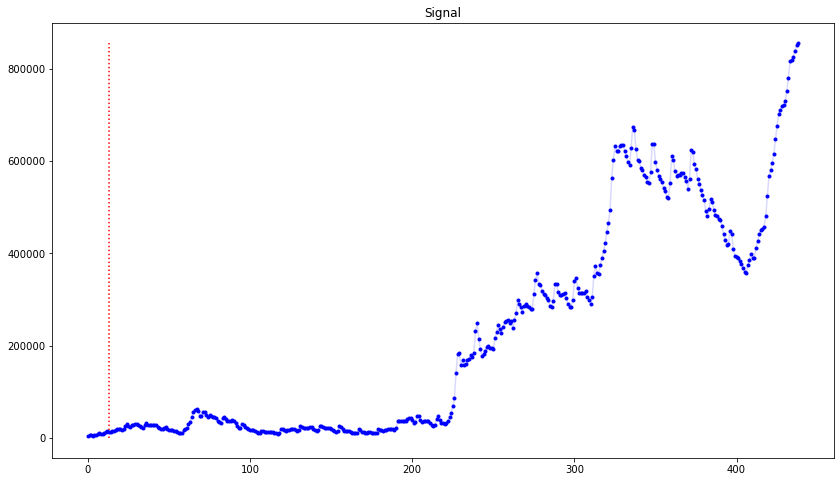

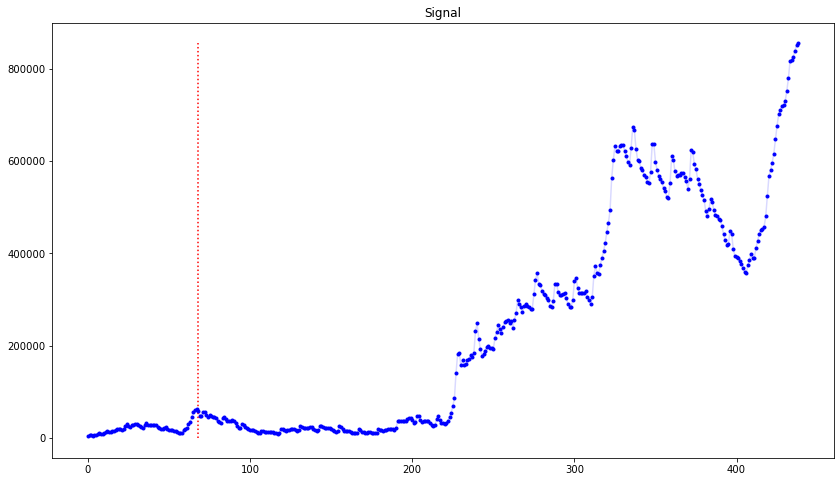

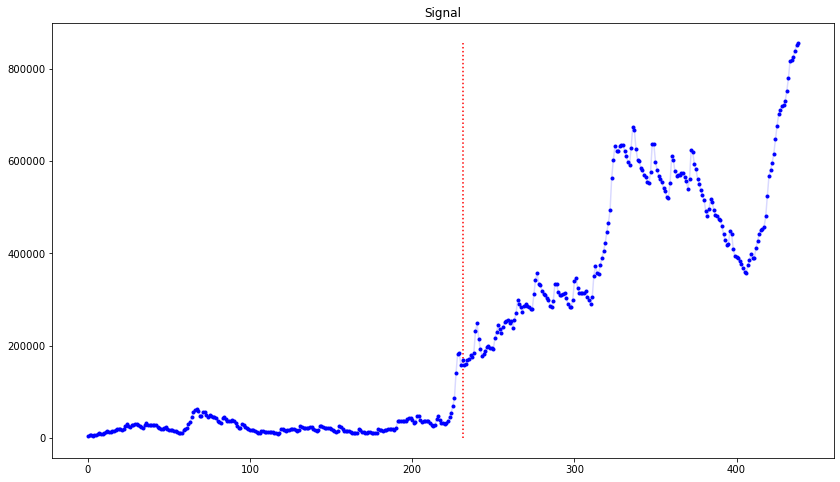

In [139]:
for a in [1, 4.7, 10]:
    simulate(ZScoreDetector(window_size=10, threshold=a), signal)

Детектор № 3

In [140]:
def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
   
    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

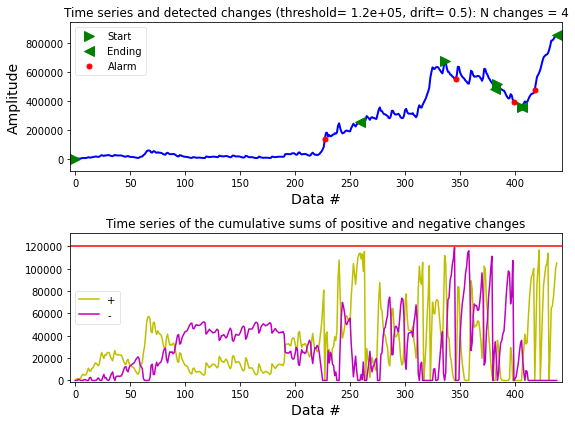

In [158]:
ta, tai, taf, amp = detect_cusum(signal, 120000, .5, True, True)

Детектор № 4

In [264]:
X_train = np.array(signal[ : 320]).reshape(-1,1)

In [265]:
X_test = np.array(signal[320 : ]).reshape(-1,1)

clf = svm.OneClassSVM(nu=0.005, kernel="rbf", gamma=0.005)
clf.fit(X_train)

In [288]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [289]:
y = np.linspace(0, 900000, 500).reshape(-1, 1)
Z = clf.decision_function(y).reshape(-1,1)
Z = np.hstack((Z, Z))
y = y.reshape(500)

In [290]:
Z.shape

(500, 2)

In [291]:
false_positive_train = []
false_positive_test = []
for i, t in enumerate(y_pred_train):
    if t != 1:
        false_positive_train.append((i, signal[i]))
        
for i, t in enumerate(y_pred_test):
    if t != 1:
        idx = len(y_pred_train) + i
        false_positive_test.append((idx, signal[idx]))

In [292]:
false_positive_train = np.array(false_positive_train)
false_positive_test = np.array(false_positive_test)

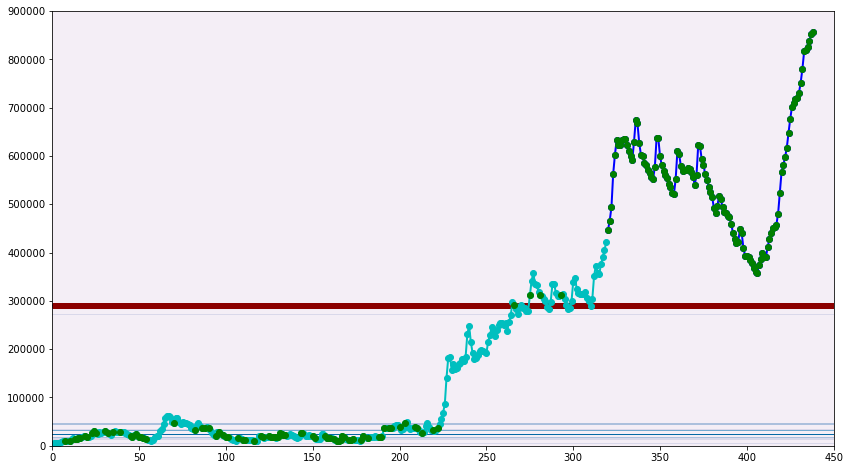

In [293]:
plt.figure(figsize=(14,8))
plt.contourf([0, 450], y, Z, cmap=plt.cm.PuBu)
plt.contour([0, 450], y, Z, levels=[0], linewidths=5, colors='darkred')
plt.plot(range(320), X_train, 'co', linewidth=10)
plt.plot(range(320), X_train, 'c-', linewidth=2)
plt.plot(range(320,439), X_test, 'bo', linewidth=10)
plt.plot(range(320,439), X_test, 'b-', linewidth=2)
plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')
plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')

plt.show()